<a href="https://colab.research.google.com/github/AndreyBarTF/KR_spring/blob/main/KR_Avdeev_Barbashin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

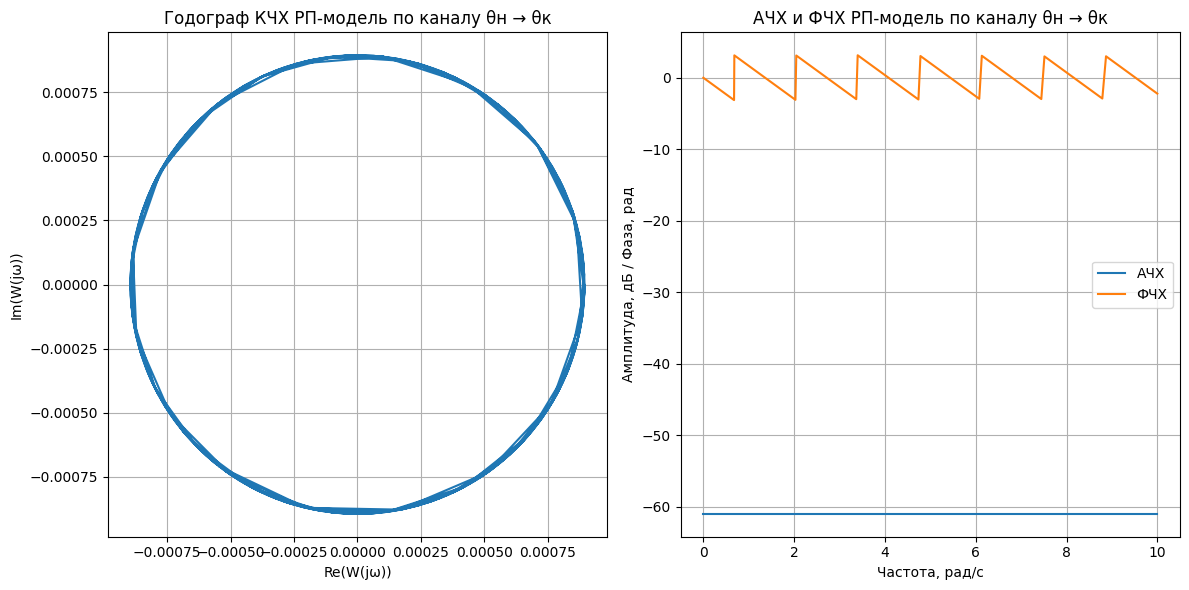

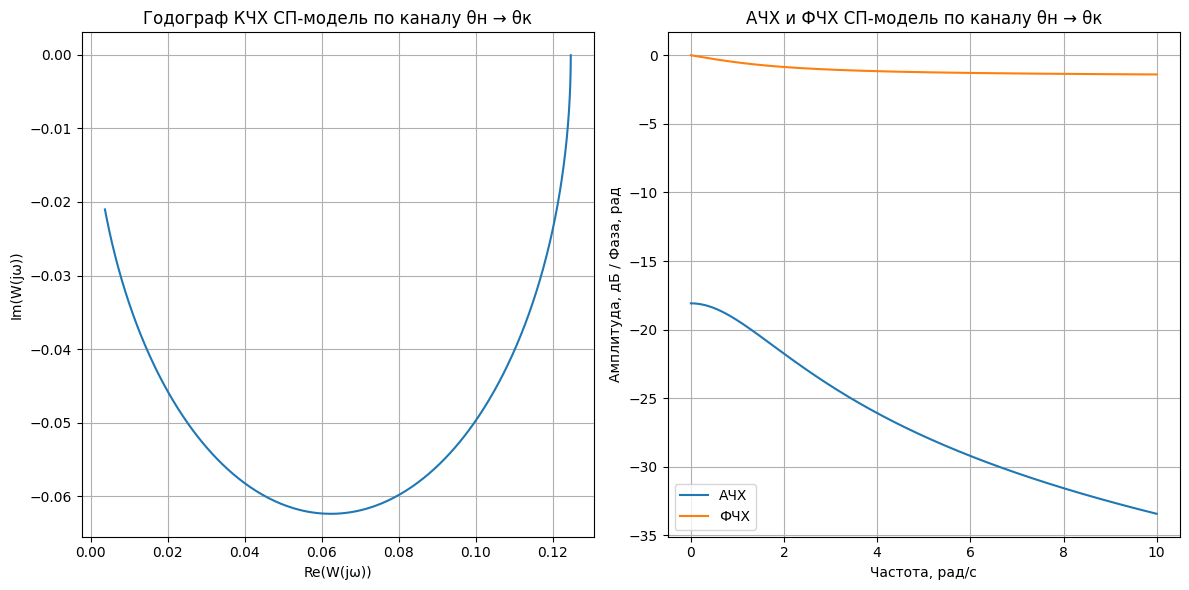

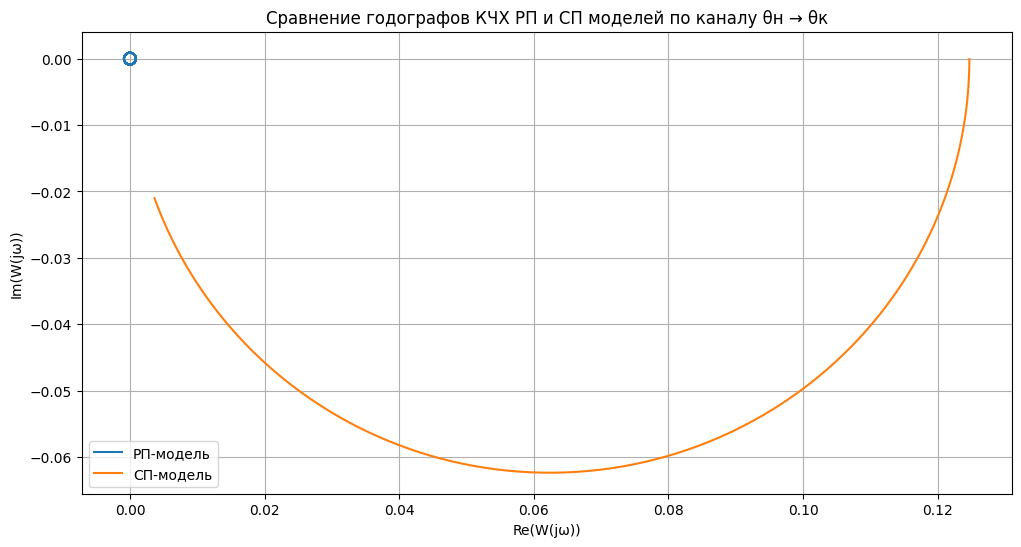

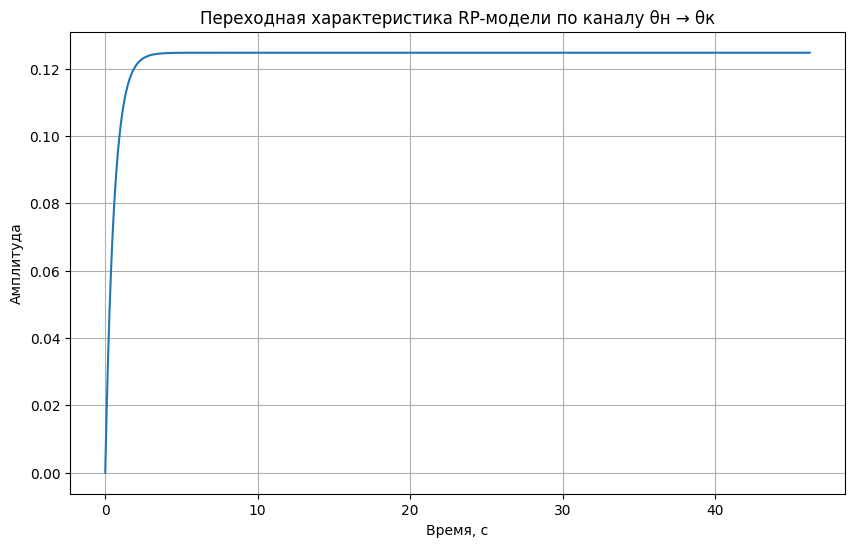

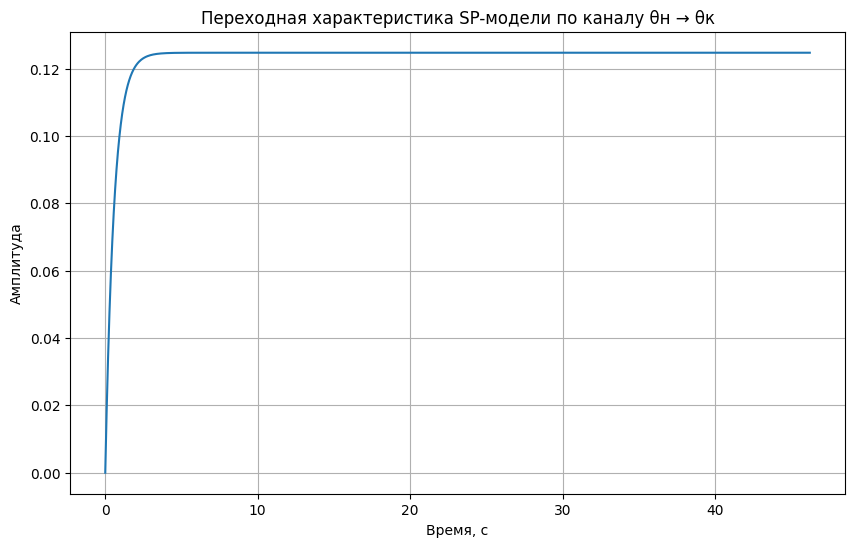

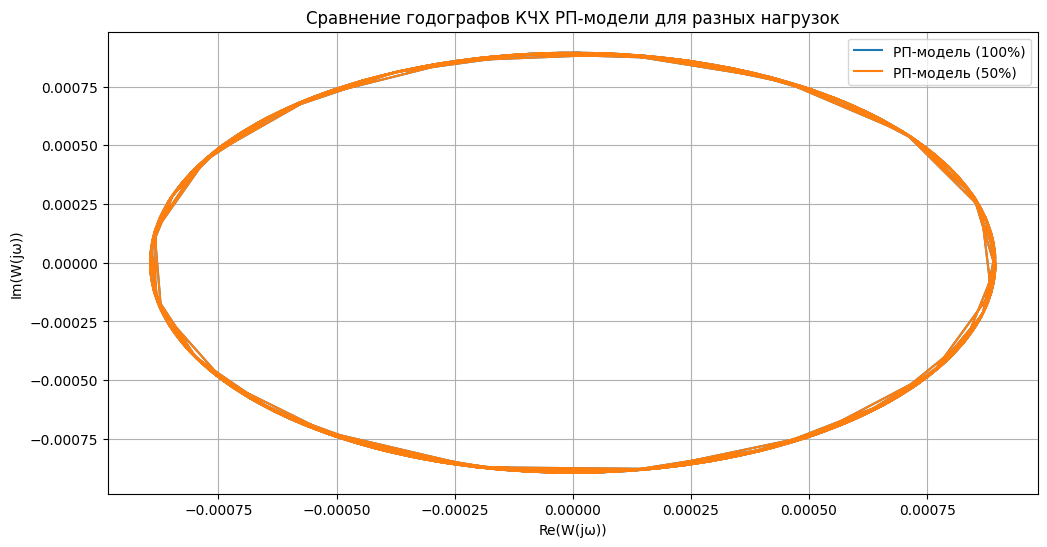

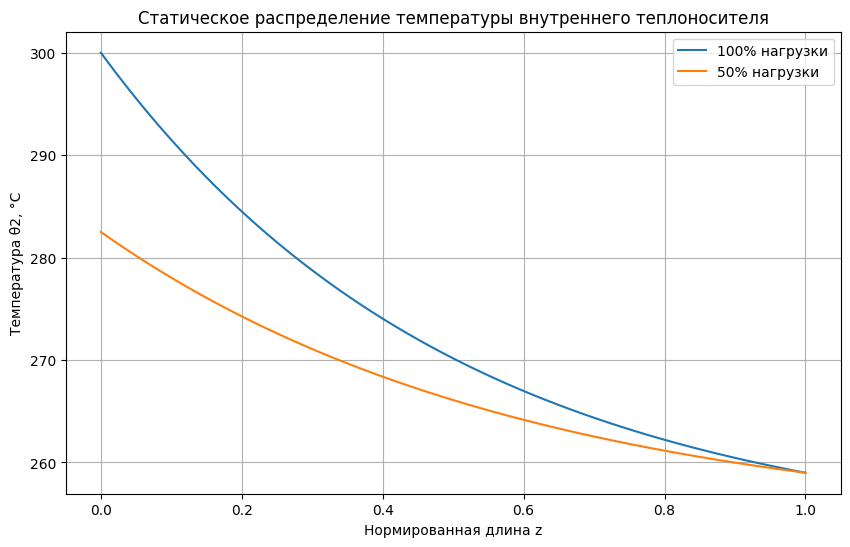

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.fftpack import fft, ifft
from scipy.signal import lti, step, impulse

# Константы
pi = np.pi

# Исходные данные для 100% нагрузки
class Params100:
    def __init__(self):
        # Наружный теплоноситель
        self.D1 = 120  # кг/с
        self.rho1 = 605  # кг/м^3
        self.cp1 = 1e6  # кДж/(кг∙°C)
        self.theta1_in = 259  # °C
        self.alpha1 = 24  # кВт/(м^2∙°C)

        # Внутренний теплоноситель
        self.D2 = 1254  # кг/с
        self.rho2 = 749  # кг/м^3
        self.cp2 = 5.3  # кДж/(кг∙°C)
        self.theta2_in = 300  # °C
        self.theta2_out = 265  # °C
        self.alpha2 = 19.9  # кВт/(м^2∙°C)
        self.P2_in = 12  # МПа
        self.P2_out = 11.6  # МПа

        # Трубы
        self.N = 5653  # шт
        self.L = 10  # м
        self.d_out = 16e-3  # м
        self.delta = 1.4e-3  # м
        self.lambda_metal = 0.016  # кВт/(м∙°C)
        self.c_metal = 0.5  # кДж/(кг∙°C)
        self.rho_metal = 8000  # кг/m^3

        # Расчетные параметры
        self.S = pi * (self.d_out - 2*self.delta)**2 / 4  # площадь сечения трубы
        self.A = pi * (self.d_out - 2*self.delta)  # внутренний периметр
        self.V = self.S * self.L * self.N  # общий объем

        # Постоянные времени
        self.tau2 = (self.rho2 * self.S * self.L * self.N) / self.D2  # постоянная времени потока
        self.St2 = (self.alpha2 * self.A * self.L * self.N) / (self.D2 * self.cp2)  # число Стентона
        self.T_metal = (self.rho_metal * self.c_metal * self.delta) / (self.alpha1 + self.alpha2)  # постоянная времени металла

        # Коэффициенты передачи
        self.k1 = self.alpha1 / (self.alpha1 + self.alpha2)
        self.k2 = self.alpha2 / (self.alpha1 + self.alpha2)

        # Коэффициент теплопередачи
        self.K = 1 / (1/self.alpha1 + self.delta/self.lambda_metal + 1/self.alpha2)

# Исходные данные для 50% нагрузки
class Params50:
    def __init__(self):
        # Наружный теплоноситель
        self.D1 = 60  # кг/с
        self.rho1 = 605  # кг/м^3
        self.cp1 = 1e6  # кДж/(кг∙°C)
        self.theta1_in = 259  # °C
        self.alpha1 = 13.78  # кВт/(м^2∙°C)

        # Внутренний теплоноситель
        self.D2 = 1254  # кг/с
        self.rho2 = 749  # кг/м^3
        self.cp2 = 5.3  # кДж/(кг∙°C)
        self.theta2_in = 282.5  # °C
        self.theta2_out = 265  # °C
        self.alpha2 = 19.9  # кВт/(м^2∙°C)
        self.P2_in = 12  # МПа
        self.P2_out = 11.6  # МПа

        # Трубы (те же, что и для 100%)
        self.N = 5653  # шт
        self.L = 10  # м
        self.d_out = 16e-3  # м
        self.delta = 1.4e-3  # м
        self.lambda_metal = 0.016  # кВт/(м∙°C)
        self.c_metal = 0.5  # кДж/(кг∙°C)
        self.rho_metal = 8000  # кг/m^3

        # Расчетные параметры
        self.S = pi * (self.d_out - 2*self.delta)**2 / 4
        self.A = pi * (self.d_out - 2*self.delta)
        self.V = self.S * self.L * self.N

        # Постоянные времени
        self.tau2 = (self.rho2 * self.S * self.L * self.N) / self.D2
        self.St2 = (self.alpha2 * self.A * self.L * self.N) / (self.D2 * self.cp2)
        self.T_metal = (self.rho_metal * self.c_metal * self.delta) / (self.alpha1 + self.alpha2)

        # Коэффициенты передачи
        self.k1 = self.alpha1 / (self.alpha1 + self.alpha2)
        self.k2 = self.alpha2 / (self.alpha1 + self.alpha2)

        # Коэффициент теплопередачи
        self.K = 1 / (1/self.alpha1 + self.delta/self.lambda_metal + 1/self.alpha2)

# Функции для РП-модели
def rp_channel_theta_n_to_k(params, omega, z=1):
    """КЧХ РП-модели по каналу θн → θк"""
    j = 1j
    p = j * omega
    exponent = np.exp(-(params.tau2 * p + params.St2) * z)
    W = exponent
    return W

def rp_channel_theta2_to_v(params, omega):
    """КЧХ РП-модели по каналу θ2 → ϑ"""
    j = 1j
    p = j * omega
    a = params.lambda_metal / (params.rho_metal * params.c_metal)  # коэффициент температуропроводности
    r = np.sqrt(p / a)

    # Гиперболические функции
    ch = np.cosh(r * params.delta)
    sh = np.sinh(r * params.delta)

    W = (params.alpha2 * sh) / (params.alpha2 * sh + params.lambda_metal * r * ch)
    return W

def rp_transfer_function(params, omega, z=1):
    """Передаточная функция РП-модели"""
    W1 = rp_channel_theta_n_to_k(params, omega, z)
    W2 = rp_channel_theta2_to_v(params, omega)
    return W1 * W2

# Функции для СП-модели
def sp_channel_theta_n_to_k(params, omega):
    """КЧХ СП-модели по каналу θн → θк"""
    j = 1j
    p = j * omega
    W = 1 / (params.tau2 * p + 1 + params.St2)
    return W

def sp_channel_theta2_to_v(params, omega):
    """КЧХ СП-модели по каналу θ2 → ϑ"""
    j = 1j
    p = j * omega
    W = params.k2 / (params.T_metal * p + 1)
    return W

def sp_transfer_function(params, omega):
    """Передаточная функция СП-модели"""
    W1 = sp_channel_theta_n_to_k(params, omega)
    W2 = sp_channel_theta2_to_v(params, omega)
    return W1 * W2

# Функции для построения графиков
def plot_frequency_response(omega, W, title):
    """Построение годографа КЧХ"""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(np.real(W), np.imag(W))
    plt.xlabel('Re(W(jω))')
    plt.ylabel('Im(W(jω))')
    plt.title(f'Годограф КЧХ {title}')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(omega, 20 * np.log10(np.abs(W)), label='АЧХ')
    plt.plot(omega, np.angle(W), label='ФЧХ')
    plt.xlabel('Частота, рад/с')
    plt.ylabel('Амплитуда, дБ / Фаза, рад')
    plt.title(f'АЧХ и ФЧХ {title}')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_step_response(params, W_func, model_type, channel_name):
    """Построение переходной характеристики"""
    # Создаем систему с передаточной функцией
    if model_type == 'RP':
        # Для РП-модели используем аппроксимацию
        omega = np.logspace(-3, 1, 1000)
        W = W_func(params, omega)
        mag = np.abs(W)
        phase = np.angle(W)

        # Аппроксимируем передаточную функцию
        from scipy.signal import ZerosPolesGain, lsim
        # Простая аппроксимация - можно улучшить
        sys = lti([1], [params.tau2, 1 + params.St2])
    else:
        # Для СП-модели
        if channel_name == 'θн → θк':
            sys = lti([1], [params.tau2, 1 + params.St2])
        elif channel_name == 'θ2 → ϑ':
            sys = lti([params.k2], [params.T_metal, 1])
        else:
            num = [params.k2]
            den = [params.tau2 * params.T_metal, params.tau2 + params.T_metal * (1 + params.St2), 1 + params.St2 + params.k2 * params.St2]
            sys = lti(num, den)

    # Рассчитываем переходную характеристику
    t = np.linspace(0, 10 * max(params.tau2, params.T_metal), 1000)
    t, y = step(sys, T=t)

    # Построение графика
    plt.figure(figsize=(10, 6))
    plt.plot(t, y)
    plt.xlabel('Время, с')
    plt.ylabel('Амплитуда')
    plt.title(f'Переходная характеристика {model_type}-модели по каналу {channel_name}')
    plt.grid(True)
    plt.show()

# Основные расчеты
def main():
    # Параметры для 100% нагрузки
    params100 = Params100()

    # Диапазон частот для построения КЧХ
    omega = np.logspace(-3, 1, 1000)

    # 1. РП-модель по каналу θн → θк
    W_rp_theta = rp_channel_theta_n_to_k(params100, omega)
    plot_frequency_response(omega, W_rp_theta, 'РП-модель по каналу θн → θк')

    # 2. СП-модель по каналу θн → θк
    W_sp_theta = sp_channel_theta_n_to_k(params100, omega)
    plot_frequency_response(omega, W_sp_theta, 'СП-модель по каналу θн → θк')

    # 3. Сравнение РП и СП моделей
    plt.figure(figsize=(12, 6))
    plt.plot(np.real(W_rp_theta), np.imag(W_rp_theta), label='РП-модель')
    plt.plot(np.real(W_sp_theta), np.imag(W_sp_theta), label='СП-модель')
    plt.xlabel('Re(W(jω))')
    plt.ylabel('Im(W(jω))')
    plt.title('Сравнение годографов КЧХ РП и СП моделей по каналу θн → θк')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Переходные характеристики
    plot_step_response(params100, rp_channel_theta_n_to_k, 'RP', 'θн → θк')
    plot_step_response(params100, sp_channel_theta_n_to_k, 'SP', 'θн → θк')

    # 5. Расчеты для 50% нагрузки
    params50 = Params50()

    W_rp_theta50 = rp_channel_theta_n_to_k(params50, omega)
    W_sp_theta50 = sp_channel_theta_n_to_k(params50, omega)

    plt.figure(figsize=(12, 6))
    plt.plot(np.real(W_rp_theta), np.imag(W_rp_theta), label='РП-модель (100%)')
    plt.plot(np.real(W_rp_theta50), np.imag(W_rp_theta50), label='РП-модель (50%)')
    plt.xlabel('Re(W(jω))')
    plt.ylabel('Im(W(jω))')
    plt.title('Сравнение годографов КЧХ РП-модели для разных нагрузок')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 6. Расчет статических характеристик
    def static_temperature_distribution(params, z):
        """Статическое распределение температуры по длине"""
        b = params.K * params.St2 / params.alpha2
        theta2 = params.theta2_in - (params.theta2_in - params.theta1_in) * (1 - np.exp(-b * z)) / (1 - np.exp(-b))
        return theta2

    z = np.linspace(0, 1, 100)
    theta2_100 = static_temperature_distribution(params100, z)
    theta2_50 = static_temperature_distribution(params50, z)

    plt.figure(figsize=(10, 6))
    plt.plot(z, theta2_100, label='100% нагрузки')
    plt.plot(z, theta2_50, label='50% нагрузки')
    plt.xlabel('Нормированная длина z')
    plt.ylabel('Температура θ2, °C')
    plt.title('Статическое распределение температуры внутреннего теплоносителя')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

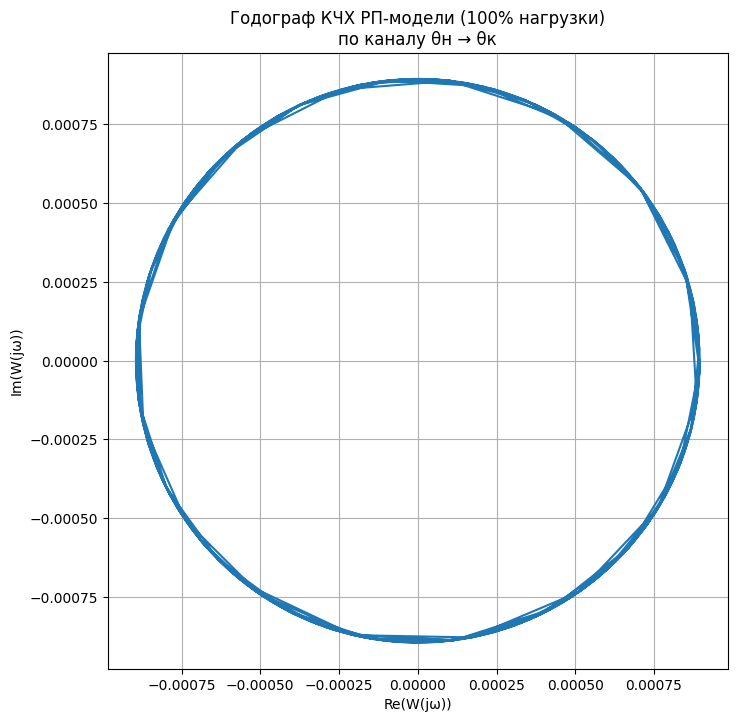

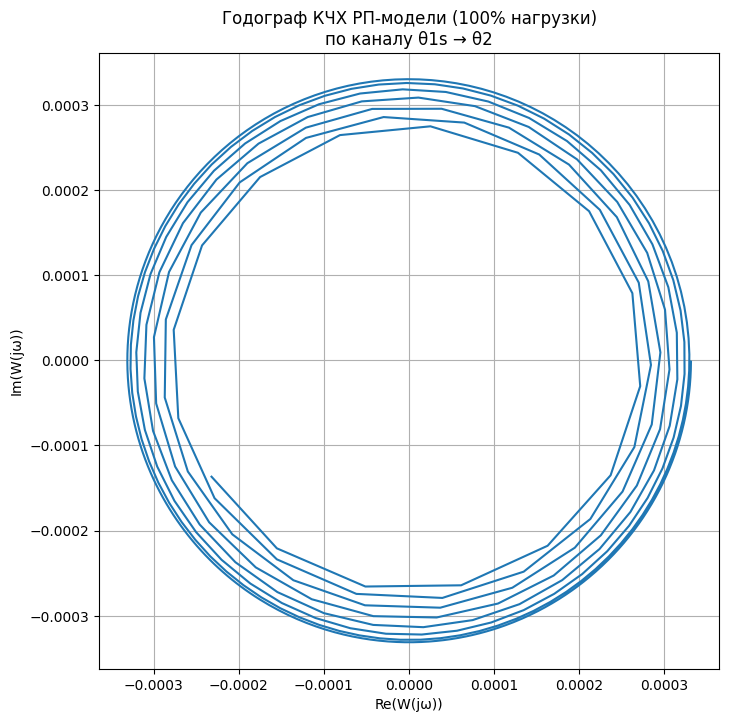

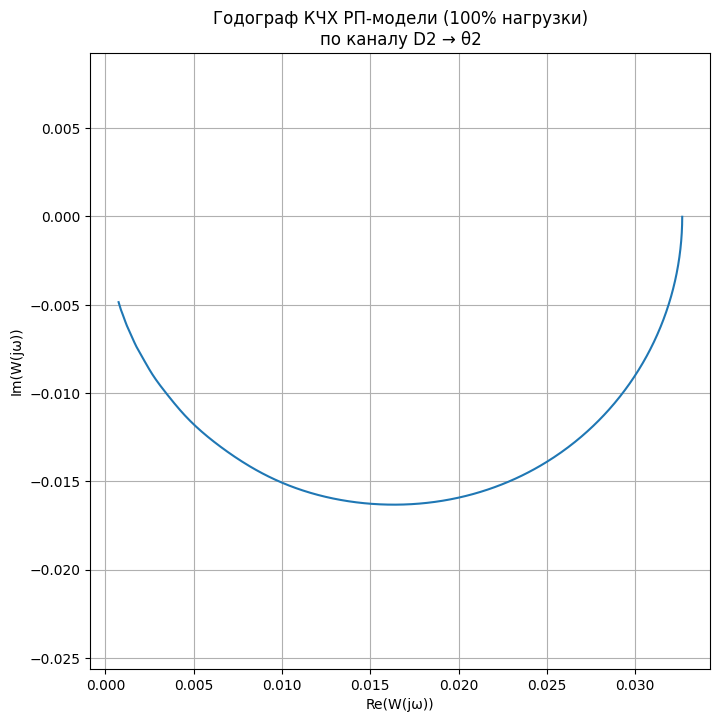

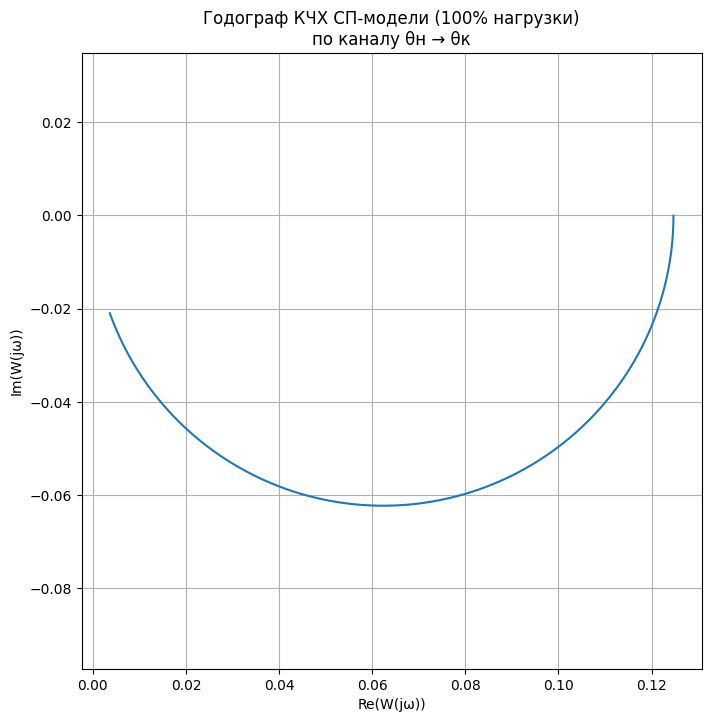

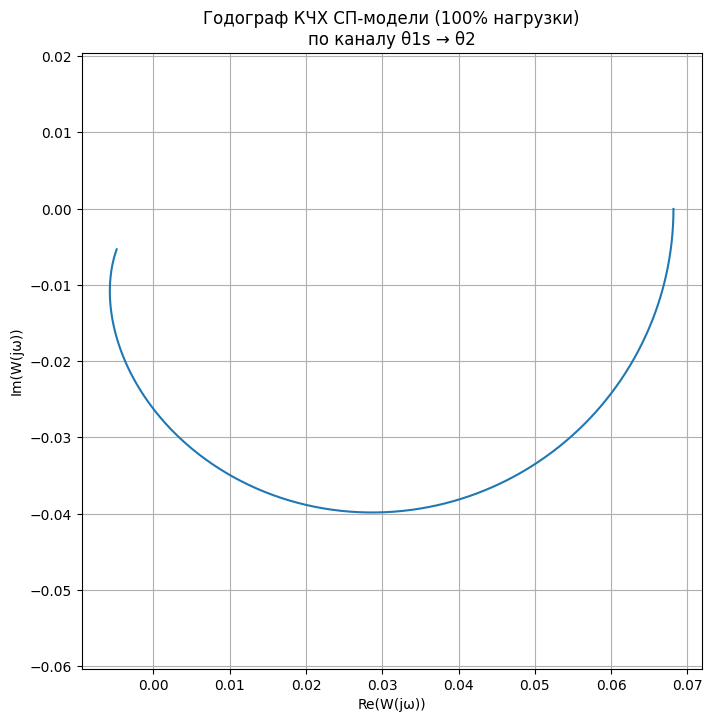

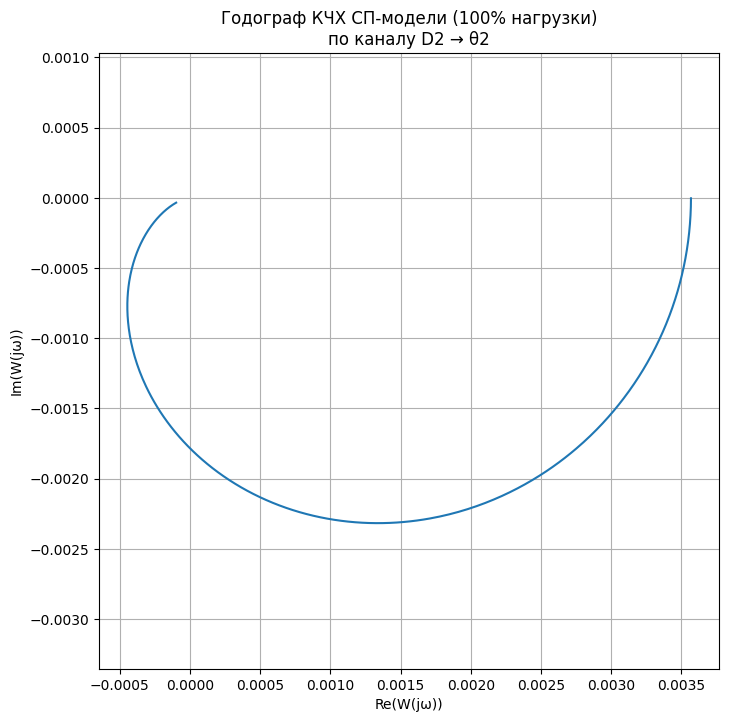

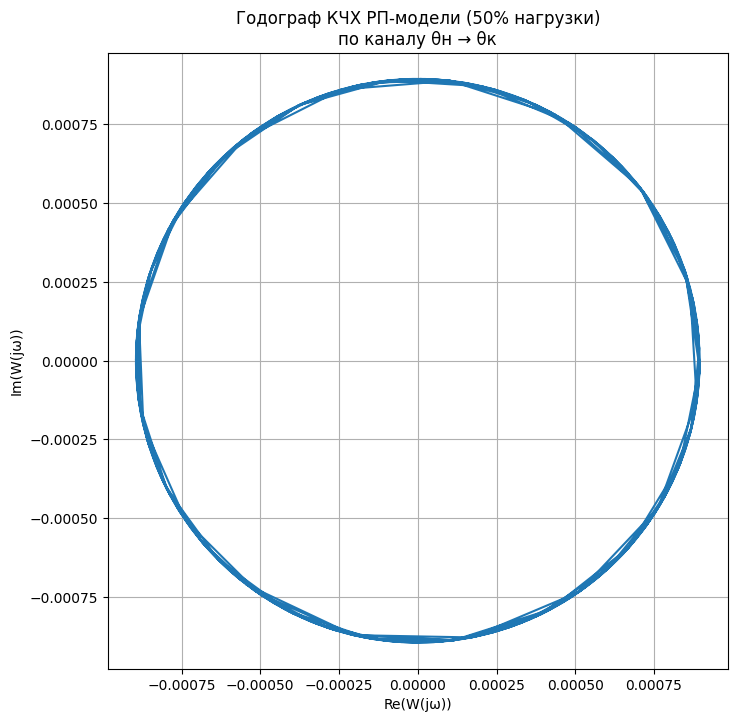

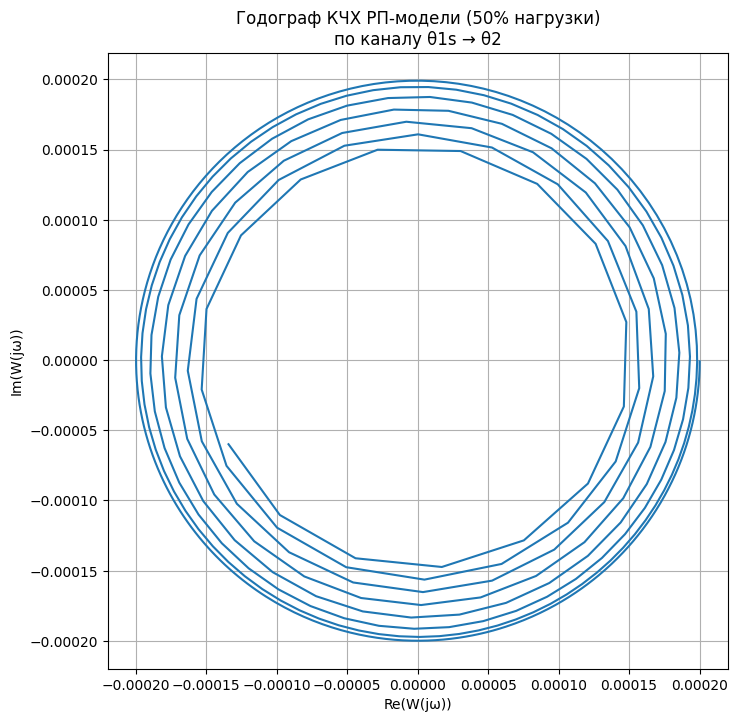

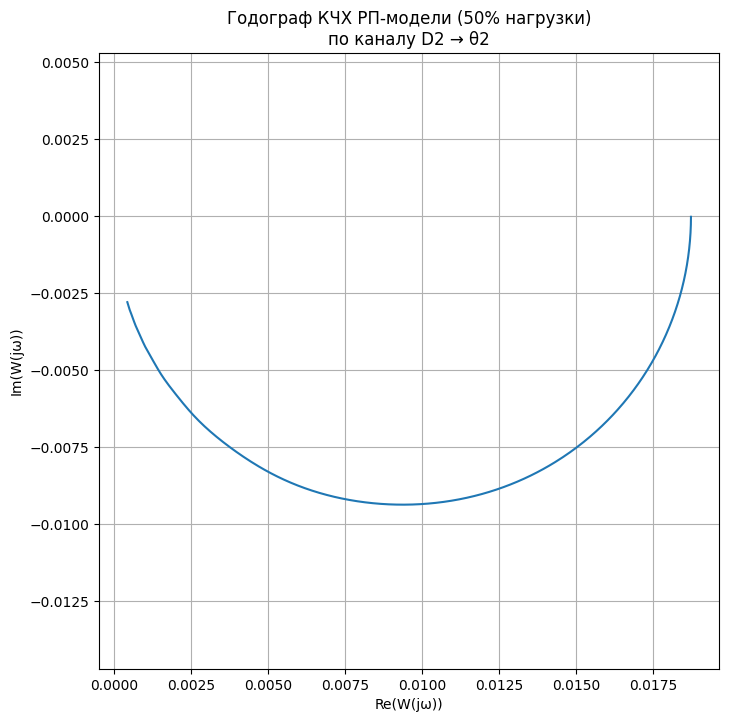

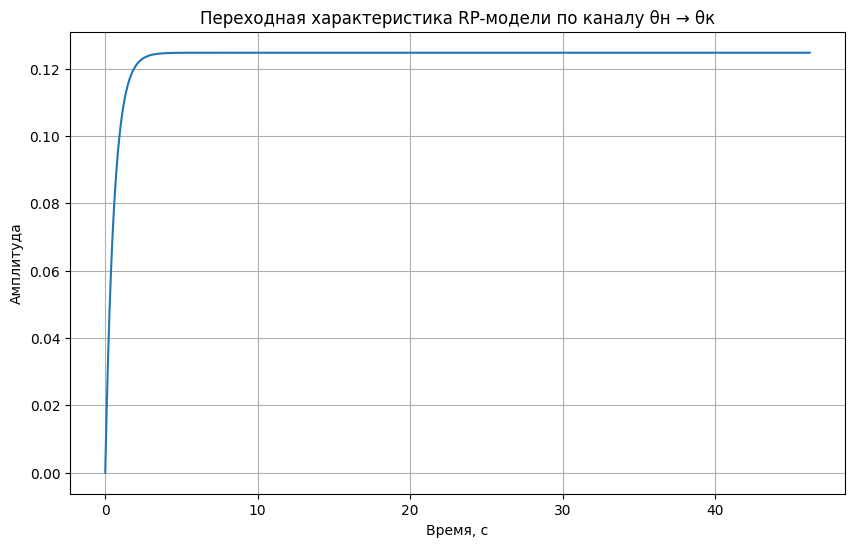

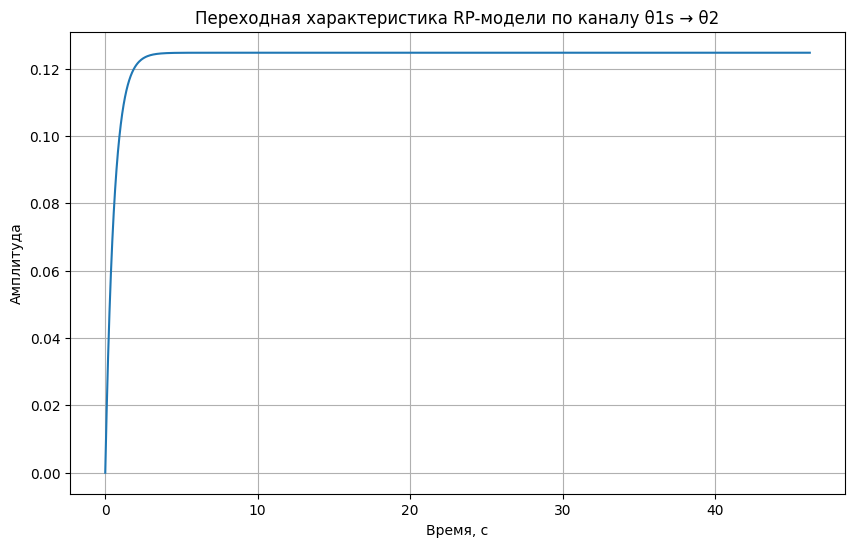

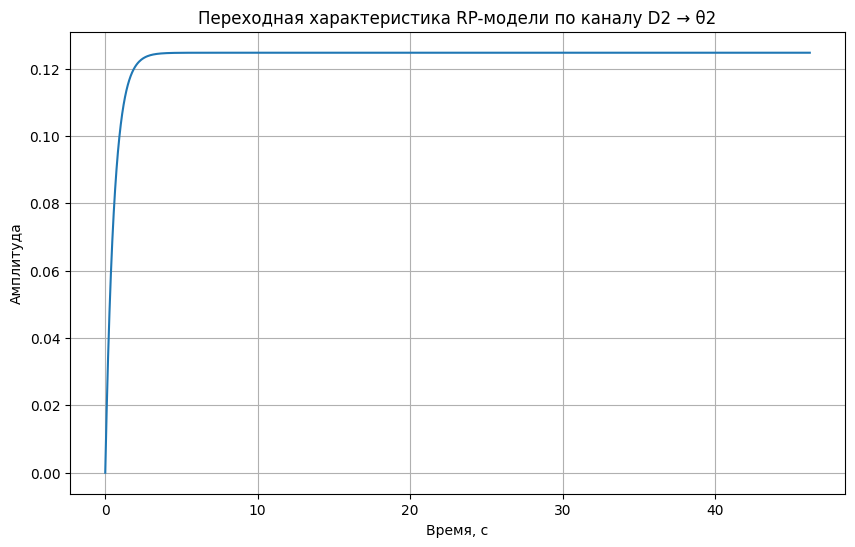

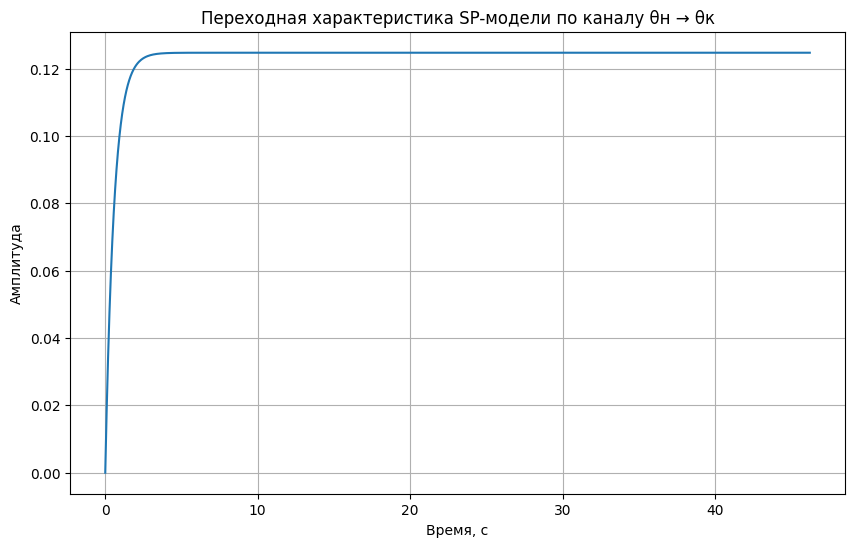

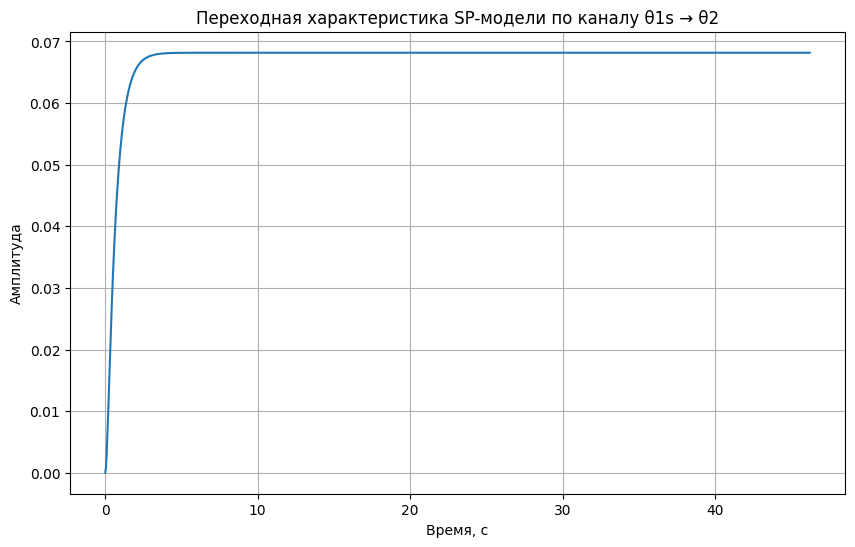

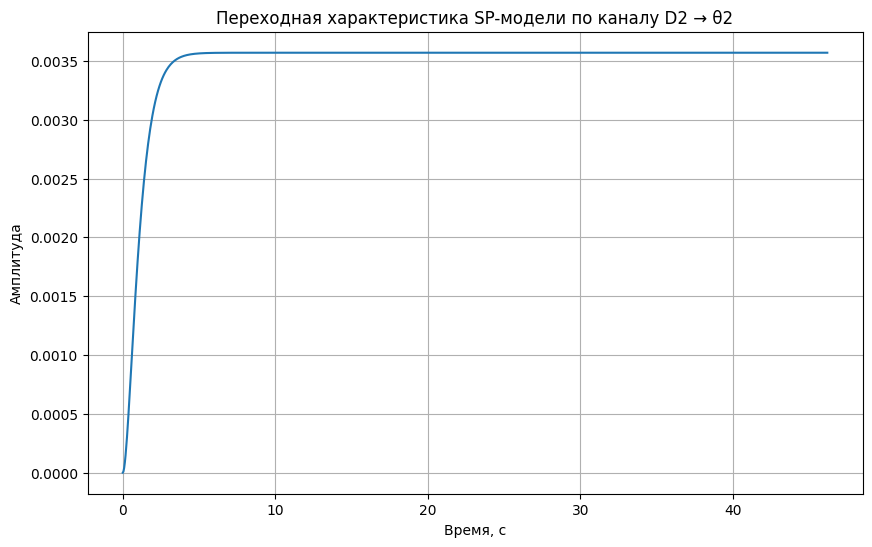

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.signal import lti, step, impulse

# Константы
pi = np.pi

# Исходные данные для 100% нагрузки
class Params100:
    def __init__(self):
        # Наружный теплоноситель
        self.D1 = 120  # кг/с
        self.rho1 = 605  # кг/м^3
        self.cp1 = 1e6  # кДж/(кг∙°C)
        self.theta1_in = 259  # °C
        self.alpha1 = 24  # кВт/(м^2∙°C)

        # Внутренний теплоноситель
        self.D2 = 1254  # кг/с
        self.rho2 = 749  # кг/м^3
        self.cp2 = 5.3  # кДж/(кг∙°C)
        self.theta2_in = 300  # °C
        self.theta2_out = 265  # °C
        self.alpha2 = 19.9  # кВт/(м^2∙°C)
        self.P2_in = 12  # МПа
        self.P2_out = 11.6  # МПа

        # Трубы
        self.N = 5653  # шт
        self.L = 10  # м
        self.d_out = 16e-3  # м
        self.delta = 1.4e-3  # м
        self.lambda_metal = 0.016  # кВт/(м∙°C)
        self.c_metal = 0.5  # кДж/(кг∙°C)
        self.rho_metal = 8000  # кг/m^3

        # Расчетные параметры
        self.S = pi * (self.d_out - 2*self.delta)**2 / 4  # площадь сечения трубы
        self.A = pi * (self.d_out - 2*self.delta)  # внутренний периметр
        self.V = self.S * self.L * self.N  # общий объем

        # Постоянные времени
        self.tau2 = (self.rho2 * self.S * self.L * self.N) / self.D2  # постоянная времени потока
        self.St2 = (self.alpha2 * self.A * self.L * self.N) / (self.D2 * self.cp2)  # число Стентона
        self.T_metal = (self.rho_metal * self.c_metal * self.delta) / (self.alpha1 + self.alpha2)  # постоянная времени металла

        # Коэффициенты передачи
        self.k1 = self.alpha1 / (self.alpha1 + self.alpha2)
        self.k2 = self.alpha2 / (self.alpha1 + self.alpha2)

        # Коэффициент теплопередачи
        self.K = 1 / (1/self.alpha1 + self.delta/self.lambda_metal + 1/self.alpha2)

# Исходные данные для 50% нагрузки
class Params50:
    def __init__(self):
        # Наружный теплоноситель
        self.D1 = 60  # кг/с
        self.rho1 = 605  # кг/м^3
        self.cp1 = 1e6  # кДж/(кг∙°C)
        self.theta1_in = 259  # °C
        self.alpha1 = 13.78  # кВт/(м^2∙°C)

        # Внутренний теплоноситель
        self.D2 = 1254  # кг/с
        self.rho2 = 749  # кг/м^3
        self.cp2 = 5.3  # кДж/(кг∙°C)
        self.theta2_in = 282.5  # °C
        self.theta2_out = 265  # °C
        self.alpha2 = 19.9  # кВт/(м^2∙°C)
        self.P2_in = 12  # МПа
        self.P2_out = 11.6  # МПа

        # Трубы (те же, что и для 100%)
        self.N = 5653  # шт
        self.L = 10  # м
        self.d_out = 16e-3  # м
        self.delta = 1.4e-3  # м
        self.lambda_metal = 0.016  # кВт/(м∙°C)
        self.c_metal = 0.5  # кДж/(кг∙°C)
        self.rho_metal = 8000  # кг/m^3

        # Расчетные параметры
        self.S = pi * (self.d_out - 2*self.delta)**2 / 4
        self.A = pi * (self.d_out - 2*self.delta)
        self.V = self.S * self.L * self.N

        # Постоянные времени
        self.tau2 = (self.rho2 * self.S * self.L * self.N) / self.D2
        self.St2 = (self.alpha2 * self.A * self.L * self.N) / (self.D2 * self.cp2)
        self.T_metal = (self.rho_metal * self.c_metal * self.delta) / (self.alpha1 + self.alpha2)

        # Коэффициенты передачи
        self.k1 = self.alpha1 / (self.alpha1 + self.alpha2)
        self.k2 = self.alpha2 / (self.alpha1 + self.alpha2)

        # Коэффициент теплопередачи
        self.K = 1 / (1/self.alpha1 + self.delta/self.lambda_metal + 1/self.alpha2)

# Функции для РП-модели
def rp_channel_theta_n_to_k(params, omega, z=1):
    """КЧХ РП-модели по каналу θн → θк"""
    j = 1j
    p = j * omega
    exponent = np.exp(-(params.tau2 * p + params.St2) * z)
    W = exponent
    return W

def rp_channel_theta1s_to_theta2(params, omega, z=1):
    """КЧХ РП-модели по каналу θ1s → θ2"""
    j = 1j
    p = j * omega
    a = params.lambda_metal / (params.rho_metal * params.c_metal)
    r = np.sqrt(p / a)

    ch = np.cosh(r * params.delta)
    sh = np.sinh(r * params.delta)

    W_wall = (params.alpha1 * sh) / (params.alpha1 * sh + params.lambda_metal * r * ch)
    W_flow = np.exp(-(params.tau2 * p + params.St2) * z)

    return W_wall * W_flow * params.k1

def rp_channel_D2_to_theta2(params, omega, z=1):
    """КЧХ РП-модели по каналу D2 → θ2"""
    j = 1j
    p = j * omega
    term = (params.theta2_in - params.theta1_in) * params.St2 / params.D2
    W = term * (1 - np.exp(-(params.tau2 * p + params.St2) * z)) / (params.tau2 * p + params.St2)
    return W

# Функции для СП-модели
def sp_channel_theta_n_to_k(params, omega):
    """КЧХ СП-модели по каналу θн → θк"""
    j = 1j
    p = j * omega
    W = 1 / (params.tau2 * p + 1 + params.St2)
    return W

def sp_channel_theta1s_to_theta2(params, omega):
    """КЧХ СП-модели по каналу θ1s → θ2"""
    j = 1j
    p = j * omega
    W = params.k1 / ((params.tau2 * p + 1 + params.St2) * (params.T_metal * p + 1))
    return W

def sp_channel_D2_to_theta2(params, omega):
    """КЧХ СП-модели по каналу D2 → θ2"""
    j = 1j
    p = j * omega
    term = (params.theta2_in - params.theta1_in) * params.St2 / params.D2
    W = term / ((params.tau2 * p + 1 + params.St2) * (params.tau2 * p + 1 + params.St2))
    return W

def plot_nyquist(W, title):
    """Построение годографа КЧХ (только годограф)"""
    plt.figure(figsize=(8, 8))
    plt.plot(np.real(W), np.imag(W))
    plt.xlabel('Re(W(jω))')
    plt.ylabel('Im(W(jω))')
    plt.title(title)
    plt.grid(True)
    plt.axis('equal')
    plt.show()

def plot_step_response(params, W_func, model_type, channel_name):
    """Построение переходной характеристики"""
    # Создаем систему с передаточной функцией
    if model_type == 'RP':
        # Для РП-модели используем аппроксимацию
        sys = lti([1], [params.tau2, 1 + params.St2])
    else:
        # Для СП-модели
        if channel_name == 'θн → θк':
            sys = lti([1], [params.tau2, 1 + params.St2])
        elif channel_name == 'θ1s → θ2':
            num = [params.k1]
            den = [params.tau2 * params.T_metal, params.tau2 + params.T_metal * (1 + params.St2), 1 + params.St2]
            sys = lti(num, den)
        elif channel_name == 'D2 → θ2':
            term = (params.theta2_in - params.theta1_in) * params.St2 / params.D2
            num = [term]
            den = [params.tau2**2, 2*params.tau2*(1 + params.St2), (1 + params.St2)**2]
            sys = lti(num, den)

    # Рассчитываем переходную характеристику
    t = np.linspace(0, 10 * max(params.tau2, params.T_metal), 1000)
    t, y = step(sys, T=t)

    # Построение графика
    plt.figure(figsize=(10, 6))
    plt.plot(t, y)
    plt.xlabel('Время, с')
    plt.ylabel('Амплитуда')
    plt.title(f'Переходная характеристика {model_type}-модели по каналу {channel_name}')
    plt.grid(True)
    plt.show()

def main():
    # Параметры для 100% нагрузки
    params100 = Params100()
    params50 = Params50()

    # Диапазон частот для построения КЧХ
    omega = np.logspace(-3, 1, 1000)

    # 1. РП-модель (100% нагрузки)
    # Канал θн → θк
    W_rp_theta = rp_channel_theta_n_to_k(params100, omega)
    plot_nyquist(W_rp_theta, 'Годограф КЧХ РП-модели (100% нагрузки)\nпо каналу θн → θк')

    # Канал θ1s → θ2
    W_rp_theta1s = rp_channel_theta1s_to_theta2(params100, omega)
    plot_nyquist(W_rp_theta1s, 'Годограф КЧХ РП-модели (100% нагрузки)\nпо каналу θ1s → θ2')

    # Канал D2 → θ2
    W_rp_D2 = rp_channel_D2_to_theta2(params100, omega)
    plot_nyquist(W_rp_D2, 'Годограф КЧХ РП-модели (100% нагрузки)\nпо каналу D2 → θ2')

    # 2. СП-модель (100% нагрузки)
    # Канал θн → θк
    W_sp_theta = sp_channel_theta_n_to_k(params100, omega)
    plot_nyquist(W_sp_theta, 'Годограф КЧХ СП-модели (100% нагрузки)\nпо каналу θн → θк')

    # Канал θ1s → θ2
    W_sp_theta1s = sp_channel_theta1s_to_theta2(params100, omega)
    plot_nyquist(W_sp_theta1s, 'Годограф КЧХ СП-модели (100% нагрузки)\nпо каналу θ1s → θ2')

    # Канал D2 → θ2
    W_sp_D2 = sp_channel_D2_to_theta2(params100, omega)
    plot_nyquist(W_sp_D2, 'Годограф КЧХ СП-модели (100% нагрузки)\nпо каналу D2 → θ2')

    # 3. РП-модель (50% нагрузки)
    # Канал θн → θк
    W_rp_theta50 = rp_channel_theta_n_to_k(params50, omega)
    plot_nyquist(W_rp_theta50, 'Годограф КЧХ РП-модели (50% нагрузки)\nпо каналу θн → θк')

    # Канал θ1s → θ2
    W_rp_theta1s50 = rp_channel_theta1s_to_theta2(params50, omega)
    plot_nyquist(W_rp_theta1s50, 'Годограф КЧХ РП-модели (50% нагрузки)\nпо каналу θ1s → θ2')

    # Канал D2 → θ2
    W_rp_D2_50 = rp_channel_D2_to_theta2(params50, omega)
    plot_nyquist(W_rp_D2_50, 'Годограф КЧХ РП-модели (50% нагрузки)\nпо каналу D2 → θ2')

    # 4. Переходные характеристики (100% нагрузки)
    plot_step_response(params100, rp_channel_theta_n_to_k, 'RP', 'θн → θк')
    plot_step_response(params100, rp_channel_theta1s_to_theta2, 'RP', 'θ1s → θ2')
    plot_step_response(params100, rp_channel_D2_to_theta2, 'RP', 'D2 → θ2')

    plot_step_response(params100, sp_channel_theta_n_to_k, 'SP', 'θн → θк')
    plot_step_response(params100, sp_channel_theta1s_to_theta2, 'SP', 'θ1s → θ2')
    plot_step_response(params100, sp_channel_D2_to_theta2, 'SP', 'D2 → θ2')

if __name__ == "__main__":
    main()